In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib import colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(threshold='nan')
import pandas as pd
import seaborn as sns
from scipy import stats
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
#from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
sys.path.append('python')
import clusterOutliers
import keplerml

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires today

    After the trial mode has expired, if you want to use mkl thereafter,
    please purchase a license at http://continuum.io
    


# Import Existing Sample Data (if it exists)

In [2]:
# the FullSample is all common points between Quarters 4, 8, 11, and 16. These files are set up as pandas dataframes
# and contain calculated features and previously computed cluster identifications.

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q4.dataSample = Q4.data
Q4.filesSample =Q4.dataSample.index
Q4.sampleGenerated = True
Q4.sampleTSNE = True

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q8_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
# This is only a sampling of the data, so the dataSample is, by definition, the data
Q8.dataSample=Q8.data
Q8.filesSample=Q8.dataSample.index
# Specify that the sample is a good one
Q8.sampleGenerated = True
# Specifying that the sample has a TSNE reduction
Q8.sampleTSNE = True

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q11_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q11.dataSample = Q11.data
Q11.filesSample =Q11.dataSample.index
Q11.sampleGenerated = True
Q11.sampleTSNE = True

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q16_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q16.dataSample = Q16.data
Q16.filesSample =Q16.dataSample.index
Q16.sampleGenerated = True
Q16.sampleTSNE = True

Q_dict = {'Q4':Q4,'Q8':Q8,'Q11':Q11,'Q16':Q16}

In [3]:
for q in Q_dict:
    print(q,Q_dict[q].data.columns[60:])

('Q8', Index([u'pca_x', u'pca_y', u'db_out'], dtype='object'))
('Q16', Index([u'db_out', u'pca_x', u'pca_y'], dtype='object'))
('Q11', Index([u'db_out', u'pca_x', u'pca_y'], dtype='object'))
('Q4', Index([u'db_out', u'pca_x', u'pca_y', u'db_cluster', u'exc_labels'], dtype='object'))


In [8]:
q11pca = Q11.pca_fit()
Q11.dataSample['pca_x']=q11pca.T[0]
Q11.dataSample['pca_y']=q11pca.T[0]

q16pca = Q16.pca_fit()
Q16.dataSample['pca_x']=q16pca.T[0]
Q16.dataSample['pca_y']=q16pca.T[0]

#Q11.save() # These have been previously generated, saving would now be redundant and 
#Q16.save() # overwrite data

In [3]:
# This is now handled on import
for q in Q_dict:
    data = Q_dict[q].data
    Q_dict[q].data['KID']=[i[:13] for i in Q_dict[q].data.index]
    Q_dict[q].data = Q_dict[q].data.set_index('KID')

In [4]:
q_int={'Q4':4,'Q8':8,'Q11':11,'Q16':16}

# numpy arrays containing all kID's for data ID'd as outliers
kid_out=dict()
for q in Q_dict:
    kid_out[q]=Q_dict[q].data.index[Q_dict[q].data.db_out==-1]

# Outliers in any quarter, not necessarily in all quarters
out_all = np.unique(np.concatenate([kid_out[q] for q in kid_out]))

# Identify outliers that are exclusive to each quarter
exc = dict()
for q in kid_out:
    out = kid_out[q]
    for p in kid_out:
        if q!=p:
            out = np.setdiff1d(out,kid_out[p])
    exc[q]=out

In [139]:
# New labels for quarter exclusive outliers.
for q in Q_dict:
    Q_dict[q].data['exc_labels']=Q_dict[q].data.db_out
    for p in Q_dict:
        Q_dict[q].data.loc[exc[p],'exc_labels']=q_int[p]

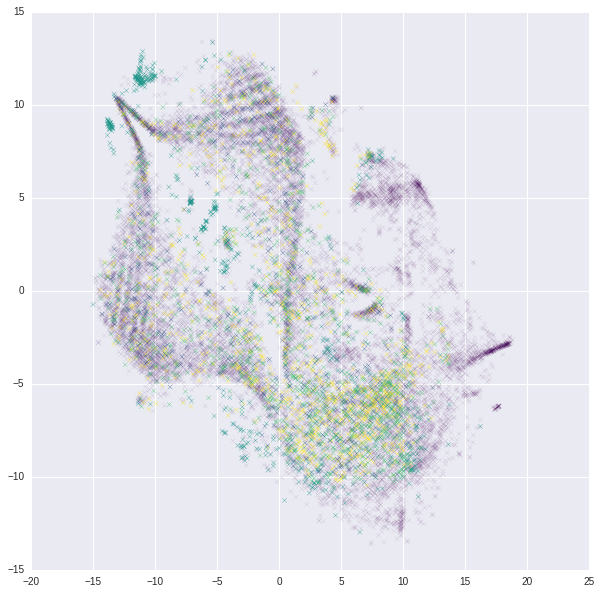

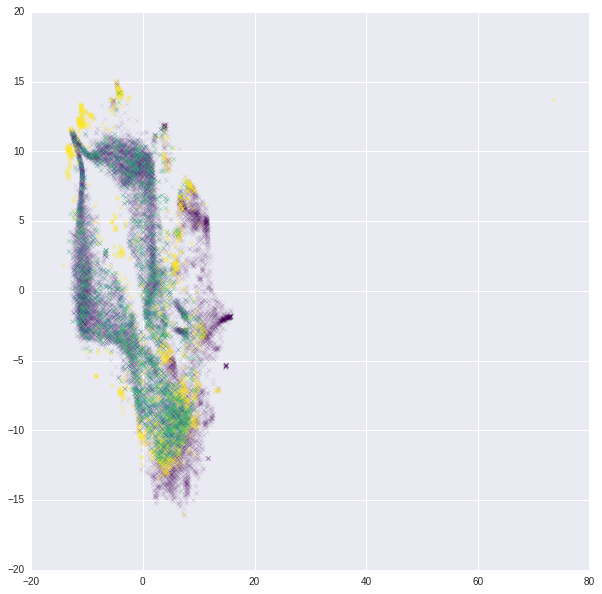

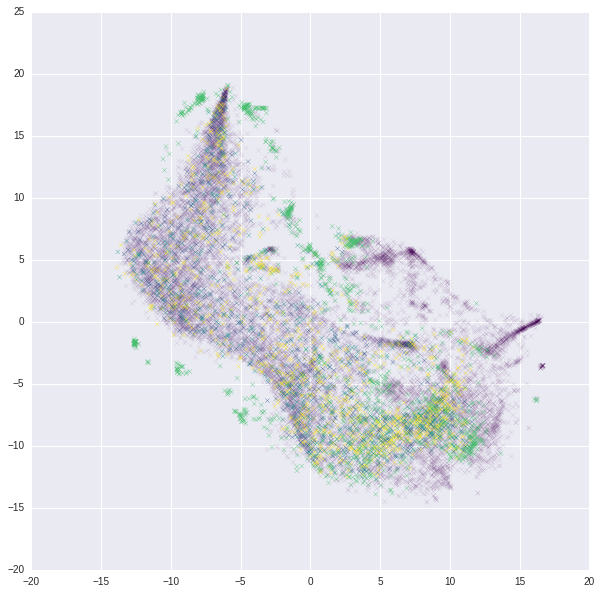

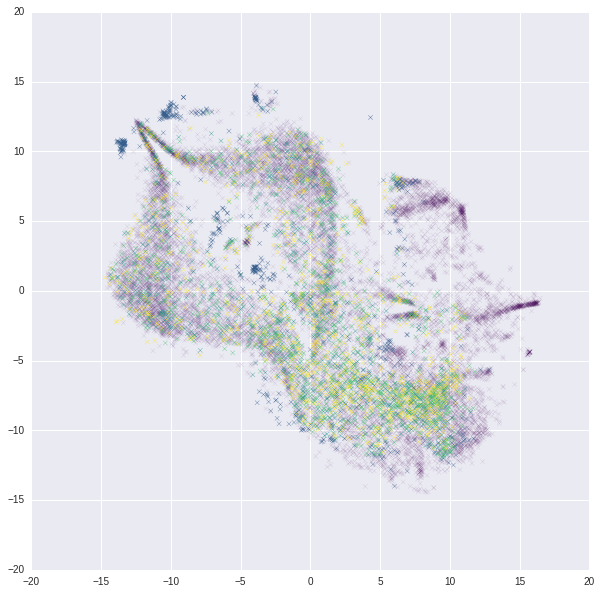

In [158]:
%matplotlib inline

def unique_plot(data):
    
    labels = data.exc_labels
    cNorm  = colors.Normalize(vmin=min(labels), vmax=max(labels))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')
    colorVal = scalarMap.to_rgba(labels)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    not_unique = data[data.exc_labels<=1]
    unique = data[data.exc_labels>1]
    ax.scatter(not_unique[not_unique.tsne_x<40].tsne_x,
               not_unique[not_unique.tsne_x<40].tsne_y,
                c=colorVal[data.exc_labels<=1],alpha=.2,marker='x')

    ax.scatter(unique.tsne_x,unique.tsne_y,
                c=colorVal[data.exc_labels>1],marker='x')

    #ax.scatter(data[data.exc_labels==q_int[q]].tsne_x,data[data.exc_labels==q_int[q]].tsne_y,
    #           c='yellow')
    plt.show()
    
for q in Q_dict:
    unique_plot(Q_dict[q].data)

#for p in Q_dict:
#    plt.scatter(data.loc[exc[p]].pca_x,data.loc[exc[p]].pca_y,c=data.loc[exc[p]].exc_labels,cmap='viridis')

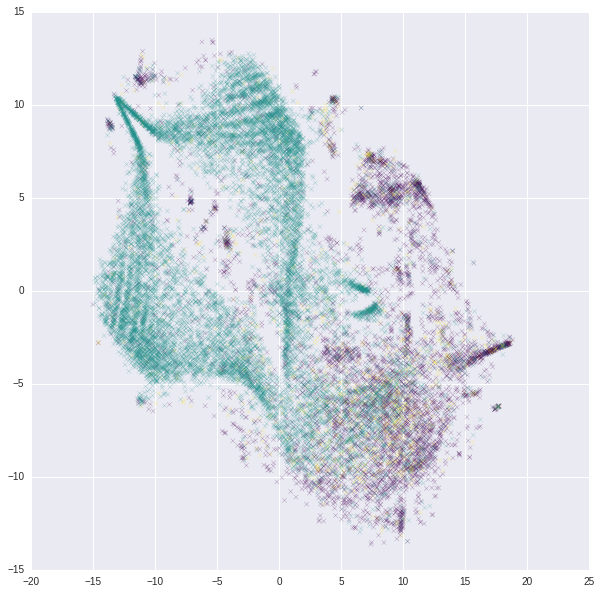

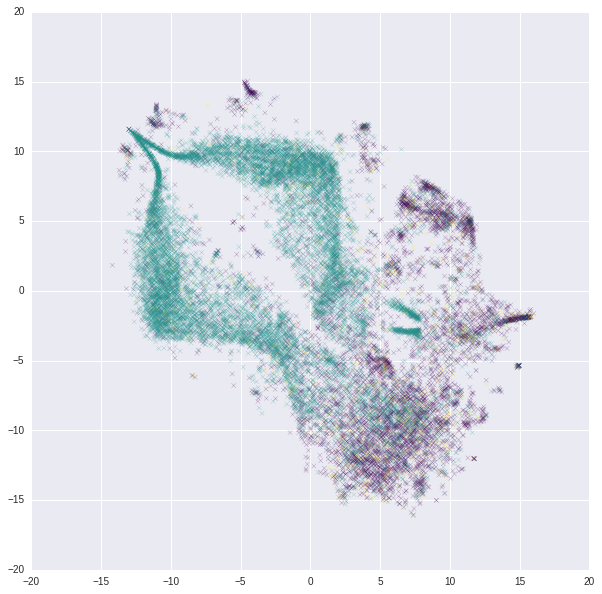

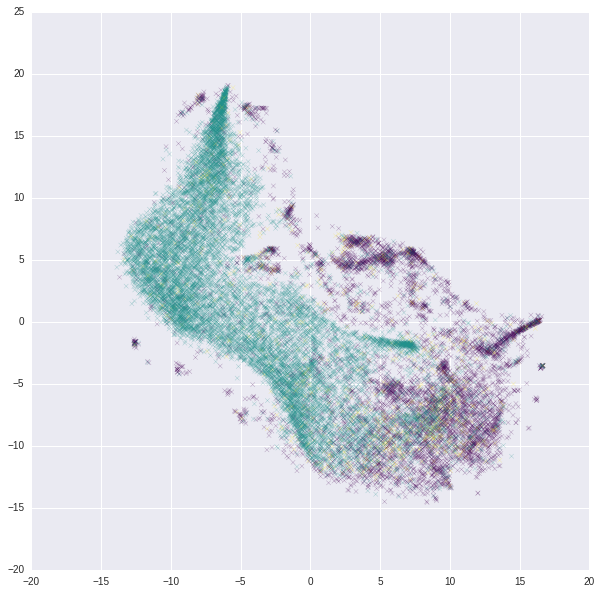

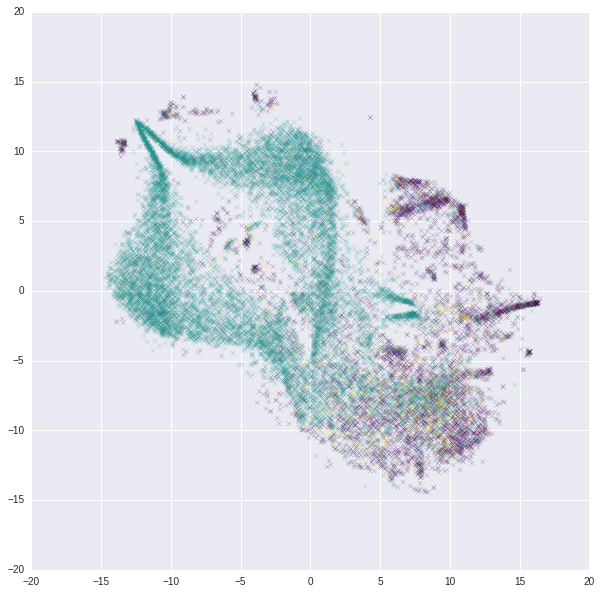

In [154]:
def Q_plot(data):
    
    labels = data.db_out
    cNorm  = colors.Normalize(vmin=min(labels), vmax=max(labels))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')
    colorVal = scalarMap.to_rgba(labels)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(data[data.tsne_x<50].tsne_x,data[data.tsne_x<50].tsne_y,
                c=colorVal,alpha=.5,marker='x')

    #ax.scatter(data[data.exc_labels==q_int[q]].tsne_x,data[data.exc_labels==q_int[q]].tsne_y,
    #           c='yellow')
    plt.show()
    
for q in Q_dict:
    Q_plot(Q_dict[q].data)

In [3]:
featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_4" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_8" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q8_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_11" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q11_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_16" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q16_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

In [4]:
tsne4 = Q4.tsne_fit(Q4_sample.data.iloc[:,0:60])
tsne8 = Q8.tsne_fit(Q8_sample.data.iloc[:,0:60])
tsne11 = Q11.tsne_fit(Q11_sample.data.iloc[:,0:60])
tsne16 = Q16.tsne_fit(Q16_sample.data.iloc[:,0:60])

[t-SNE] Computing 5551 nearest neighbors...
[t-SNE] Indexed 18507 samples in 0.122s...
[t-SNE] Computed neighbors for 18507 samples in 52.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18507
[t-SNE] Computed conditional probabilities for sample 2000 / 18507
[t-SNE] Computed conditional probabilities for sample 3000 / 18507
[t-SNE] Computed conditional probabilities for sample 4000 / 18507
[t-SNE] Computed conditional probabilities for sample 5000 / 18507
[t-SNE] Computed conditional probabilities for sample 6000 / 18507
[t-SNE] Computed conditional probabilities for sample 7000 / 18507
[t-SNE] Computed conditional probabilities for sample 8000 / 18507
[t-SNE] Computed conditional probabilities for sample 9000 / 18507
[t-SNE] Computed conditional probabilities for sample 10000 / 18507
[t-SNE] Computed conditional probabilities for sample 11000 / 18507
[t-SNE] Computed conditional probabilities for sample 12000 / 18507
[t-SNE] Computed conditional probabilities for 

In [183]:
%matplotlib inline

from matplotlib import colors
import matplotlib.cm as cmx

def four_panel(data):
    labels = data.db_out
    outliers = data[labels==-1]
    core = data[labels==0]
    edge = data[labels==1]
    
    cNorm  = colors.Normalize(vmin=min(labels), vmax=max(labels))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')
    colorVal = scalarMap.to_rgba(labels)

    fig = plt.figure(figsize=(15,30))
    ax1 = fig.add_subplot(422)

    ax1.scatter(outliers[outliers.tsne_x<40].tsne_x,
                outliers[outliers.tsne_x<40].tsne_y,
                c=colorVal[labels==-1][outliers.tsne_x<40],
                marker='.',alpha=.2)
    ax1.set_title('Outliers')

    ax2 = fig.add_subplot(421)
    ax2.scatter(core.tsne_x,
                core.tsne_y,
                c=colorVal[labels==0],
                marker='.',alpha=.2)
    ax2.set_title('Cluster Core Members')

    ax3 = fig.add_subplot(423)
    ax3.scatter(edge.tsne_x,
                edge.tsne_y,
                c=colorVal[labels==1],
                marker='.',alpha=.2)
    ax3.set_title('Cluster Edge Members')
    
    ax4 = fig.add_subplot(424)
    ax4.scatter(data[data.tsne_x<40].tsne_x,
                data[data.tsne_x<40].tsne_y,
                c=colorVal[data.tsne_x<40],
                marker='.',alpha=.2)
    ax4.set_title('All data')
    
    ax1.set_xlim(ax4.get_xlim())
    ax1.set_ylim(ax4.get_ylim())
    ax2.set_xlim(ax4.get_xlim())
    ax2.set_ylim(ax4.get_ylim())
    ax3.set_xlim(ax4.get_xlim())
    ax3.set_ylim(ax4.get_ylim())

    return

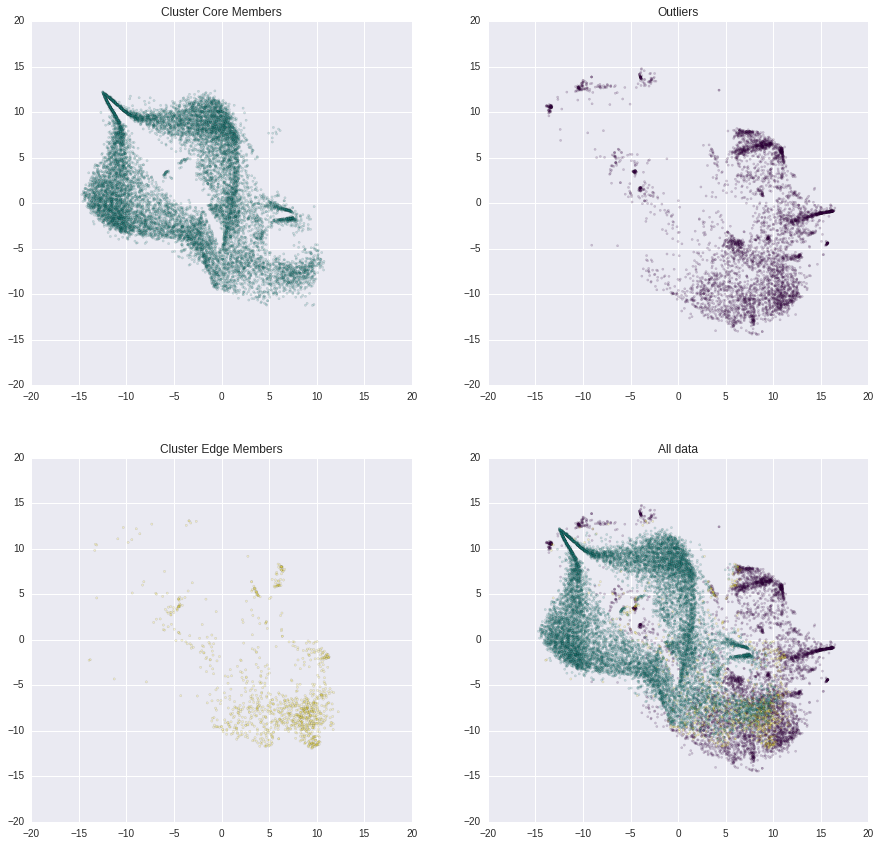

In [184]:
four_panel(Q4_sample.data)

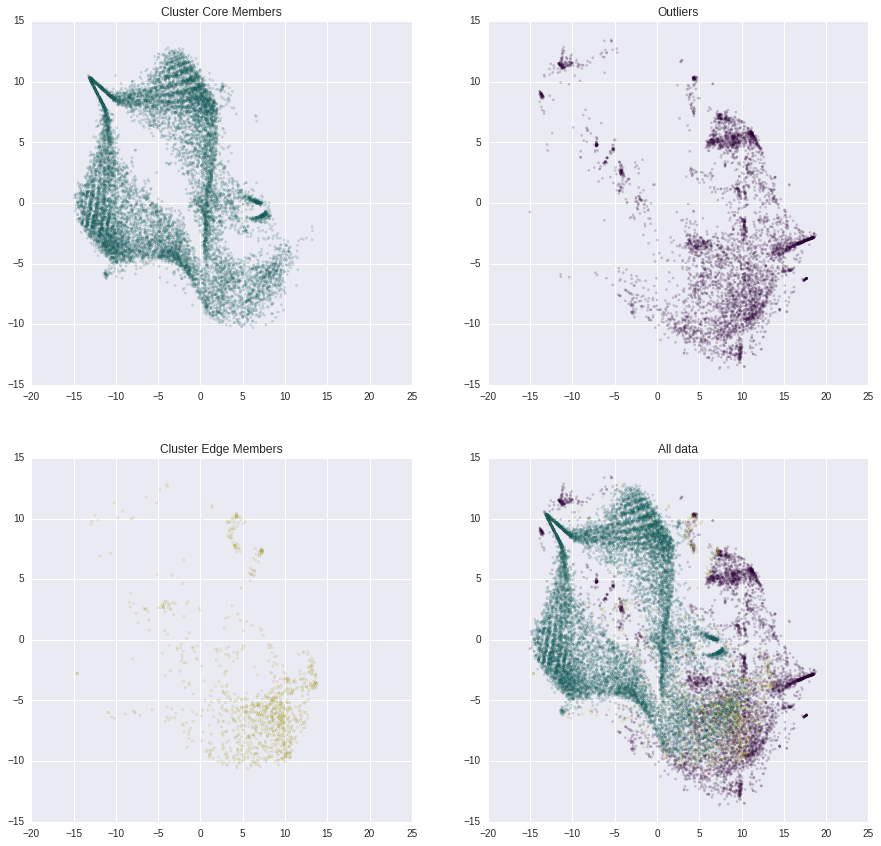

In [185]:
four_panel(Q8_sample.data)

In [24]:
from sklearn import preprocessing
def scale_sample(df):
    data = df.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaledData = scaler.transform(data)
    df_scaled = pd.DataFrame(columns=df.columns[0:60],index = df           .index,data=scaledData)
    
    return df_scaled

In [16]:
from datetime import datetime
from sklearn import preprocessing
def cluster_sample(q):
    
    Qob = Q_dict[q]
    Qdf = Qob.dataSample
    df_scaled = scale_sample(Qdf)
    dbout = Qob.db_out(df_scaled,check_tabby=True)
    
    return dbout

In [17]:
start = datetime.now()
Q8.dataSample['db_out'] = cluster_sample('Q8')

print(datetime.now()-start)

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.09.
        
Scaling density...
Clustering data with DBSCAN, eps=04.09,min_samples=56...
Tabby has been found to be an outlier in DBSCAN.
There were 2 clusters and 5041 total outliers
0:14:45.992268


In [53]:
from sklearn.cluster import DBSCAN

In [54]:
df = scale_sample(Q8.dataSample)
start = datetime.now()
est = DBSCAN(eps=4.09,min_samples=56,algorithm='ball_tree',n_jobs=-1)
est.fit(df)
print(datetime.now()-start)
print(len(est.labels_[est.labels_==-1]))



1:21:49.619896
5032


In [6]:
from sklearn.neighbors import NearestNeighbors
def near_neighbors(q):
    Qob = Q_dict[q]
    Q = Qob.dataSample
    data = Q.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaledData = scaler.transform(data)
    df_scaled = pd.DataFrame(columns=Q.columns[0:60],index = Q.index,data=scaledData)

    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree',n_jobs=-1).fit(df_scaled)
    distances, indices = nbrs.kneighbors(df_scaled)
    return distances, indices

distances, indices = near_neighbors('Q8')

In [22]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [23]:
def eps_est(data,n=4,verbose=True):
    # distance array containing all distances
    if verbose:print("Calculating nearest neighbor distances...")
    nbrs = NearestNeighbors(n_neighbors=max(n+1,100), algorithm='ball_tree',n_jobs=-1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    del nbrs
    distArr = distances[:,n]
    distArr.sort()
    del distances
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point)
    # where the mean of the following [number] points
    # is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
    
    number = int(np.ceil(len(data)/500))
    cutoff = 1.05
    if verbose:print("Finding elbow...")
    
    for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
            dbEps = distArr[i]
            pt=pts[i]
            break

    if verbose:
        print("""
        Epsilon is in the neighborhood of {:05.2f}.
        """.format(dbEps))
    return dbEps,distArr

In [7]:
def dbscan_w_outliers(data,min_n=4,check_tabby=False,verbose=True):
    min_n=int(np.ceil(len(data)/50))
    # numpy array of dataframe for fit later
    X=np.array([np.array(data.loc[i]) for i in data.index])
    if verbose:print("Estimating Parameters...")
    if len(X)>10000:
        # Large datasets have presented issues where a single high density cluster 
        # leads to an epsilon of 0.0 for 4 neighbors.
        # We adjust for this by calculating epsilon with 4 neighbors
        # for a sample of the data, then we scale min_neighbors accordingly.
        if verbose:print("Sampling data for parameter estimation...")
        X_sample = data.sample(n=10000)
    else:
        X_sample = data
    dbEps,distArr = eps_est(X_sample,n=min_n,verbose=verbose)
    
    if verbose:print("Clustering data with DBSCAN, eps={:05.2f},min_samples={}...".format(dbEps,min_n))
    est = DBSCAN(eps=dbEps,min_samples=min_n,n_jobs=-1)
    est.fit(X)
    clusterLabels = est.labels_
    # Outlier score: distance to 4th neighbor?

    if check_tabby:
        if data.index.str.contains('8462852').any():
            tabbyInd = list(data.index).index(data[data.index.str.contains('8462852')].index[0])
            if clusterLabels[tabbyInd] == -1:
                print("Tabby has been found to be an outlier in DBSCAN.")
            else:
                print("Tabby has NOT been found to be an outlier in DBSCAN")
        else:
            print("MISSING: Tabby is not in this data.")
                     
    numout = len(clusterLabels[clusterLabels==-1])
    numclusters = max(clusterLabels+1)
    if verbose:
        if numclusters==1:
            print("There was %s cluster and %s total outliers"%(numclusters,numout))
        else:
            print("There were %s clusters and %s total outliers"%(numclusters,numout))

    return clusterLabels

In [ ]:
from datetime import datetime
from sklearn import preprocessing
def cluster_sample(q):
    
    Qob = Q_dict[q]
    Q = Qob.dataSample
    data = Q.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaledData = scaler.transform(data)
    df_scaled = pd.DataFrame(columns=Q.columns[0:60],index = Q.index,data=scaledData)
    
    
    return Qob.db_out(df_scaled,check_tabby=True)

start = datetime.now()
Q4.dataSample['db_out'] = cluster_sample('Q4')
print(datetime.now()-start)

start = datetime.now()
Q8.dataSample['db_out'] = cluster_sample('Q8')
print(datetime.now()-start)

start = datetime.now()
Q11.dataSample['db_out'] = cluster_sample('Q11')
print(datetime.now()-start)

start = datetime.now()
Q16.dataSample['db_out'] = cluster_sample('Q16')
print(datetime.now()-start)

Estimating Parameters...

        Epsilon is in the neighborhood of 21.763520029.
        
Clustering data with DBSCAN...


In [9]:
for q in Q_dict:
    pca = Q_dict[q].pca_fit(Q_dict[q].dataSample.iloc[:,0:60])
    Q_dict[q].dataSample['pca_x'] = pca.T[0]
    Q_dict[q].dataSample['pca_y'] = pca.T[1]

In [12]:
def cluster_sample(q):
    start = datetime.now()
    Q = q.outliers
    data = Q.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaledData = scaler.transform(data)
    df_scaled = pd.DataFrame(columns=Q.columns[0:60],index = Q.index,data=scaledData)
    db_labels = q.db_out(df_scaled)
    print(datetime.now()-start)

    return db_labels

for q in Q_dict:
    Q = Q_dict[q]
    Q.outliers = Q.dataSample[Q.dataSample.db_out == -1]
    Q.outliers['out_out'] = cluster_sample(Q)

Estimating Parameters...

    Epsilon is in the neighborhood of 6.94193875491, 
    with an average of 790.0 neighbors within epsilon,
    395.0 neighbors in half circle (neighbors/2).
    
Clustering data with DBSCAN...
Tabby has not Not found to be an outlier in DBSCAN
There were 1 clusters and 213 total outliers
0:00:06.940155


/home/dgiles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Estimating Parameters...

    Epsilon is in the neighborhood of 7.10991455506, 
    with an average of 1121.0 neighbors within epsilon,
    560.5 neighbors in half circle (neighbors/2).
    
Clustering data with DBSCAN...
Tabby has not Not found to be an outlier in DBSCAN
There were 1 clusters and 236 total outliers
0:00:13.435256
Estimating Parameters...

    Epsilon is in the neighborhood of 6.12068023561, 
    with an average of 880.0 neighbors within epsilon,
    440.0 neighbors in half circle (neighbors/2).
    
Clustering data with DBSCAN...
There were 1 clusters and 372 total outliers
0:00:07.660973
Estimating Parameters...

    Epsilon is in the neighborhood of 5.96482020724, 
    with an average of 810.0 neighbors within epsilon,
    405.0 neighbors in half circle (neighbors/2).
    
Clustering data with DBSCAN...
There were 1 clusters and 356 total outliers
0:00:06.505793


In [24]:
import pyfits
from matplotlib.widgets import Slider
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import km_outliers
root = Tk.Tk()
root.wm_title("Scatter")
from IPython.display import clear_output
from accelerate.cuda import cuda

"""--- import light curve data ---"""

Qdict = {'Q4':Q4,'Q8':Q8,'Q11':Q11,'Q16':Q16}
Q = Qdict['Q8']
Qdf = Q.data
pathtofits = Q.fitsDir
files = Qdf.index
clusterLabels=Qdf.db_out


cmap = matplotlib.cm.ScalarMappable(\
    norm=matplotlib.colors.Normalize(vmin=min(clusterLabels),vmax=max(clusterLabels)),\
    cmap='viridis')
# data is an array containing each data point
data = np.array(Qdf[['tsne_x','tsne_y']])

# tsneX has all the x-coordinates
tsneX = Qdf.tsne_x
# tsneY has all the y-coordinates
tsneY = Qdf.tsne_y

data_out = Qdf[clusterLabels==-1]
outX = data_out.tsne_x
outY = data_out.tsne_y
files_out = data_out.index

data_cluster = Qdf[clusterLabels!=-1]
clusterX = data_cluster.tsne_x
clusterY = data_cluster.tsne_y
files_cluster = data_cluster.index


"""--- Organizing data and Labels ---"""


if Qdf.index.str.contains('8462852').any():
    tabbyInd = list(Qdf.index).index(Qdf[Qdf.index.str.contains('8462852')].index[0])            
else:
    tabbyInd = 0
fig = Figure(figsize=(20,10))

# a tk.DrawingArea
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
# Toolbar to help navigate the data (pan, zoom, save image, etc.)
toolbar = NavigationToolbar2TkAgg(canvas, root)
toolbar.update()
canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)

gs = gridspec.GridSpec(22,6)

def eps_est(data,n):
    
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.1*len(data))), algorithm='ball_tree',n_jobs=-1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    # Distance to 2*N/100th instead of 4th because: ... reasons
    neighbors = n
    distArr = distances[:,neighbors]
    distArr.sort()
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point)
    # where the mean of the following [number] points
    # is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
    
    number = 5
    cutoff = 1.05
    for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
            dbEps = distArr[i]
            pt=pts[i]
            break
            
    return dbEps

with sns.axes_style("white"):
    # empty subplot for scattered data
    ax = fig.add_subplot(gs[0:7,:4])
    # empty subplot for lightcurves
    ax2 = fig.add_subplot(gs[9:18,:])
    # empty subplot for center detail
    ax3 = fig.add_subplot(gs[0:7,4:])
    
    min_points = 4
    eps = eps_est(data,min_points)
    ax_s_min_n = fig.add_subplot(gs[20,:])
    ax_s_eps = fig.add_subplot(gs[21,:])
    s_neighbors = Slider(ax_s_min_n,'Neighbors',1,50,valinit=min_points,valfmt='%2i')
    s_eps = Slider(ax_s_eps,'Epsilon',.01,10,valinit=eps,valfmt='%8.3f')
    
# Set those labels
ax.set_xlabel("Reduced X",fontsize=18)
ax.set_ylabel("Reduced Y",fontsize=18)

ax3.set_title("Center Density Detail")
ax3.set_xlabel("Reduced X",fontsize=18)
ax3.set_ylabel("Reduced Y",fontsize=18)    

def read_kepler_curve(file):
    """
    Given the path of a fits file, this will extract the light curve and normalize it.
    """

    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')

    err = err[np.isfinite(t)]
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    err = err[np.isfinite(f)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    err = err/np.median(f)
    nf = f / np.median(f)

    return t, nf, err
    
@cuda.jit
def distance_cuda(dx,dy,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw + 1
    if i>len(dd):
        return

    # d_ph is a distance placeholder
    d_ph = (dx[i]-dx[0])**2+(dy[i]-dy[0])**2

    dd[i]=d_ph**.5
    return

def distances(pts,ex,ey):
    # Calculates distances between N points
    pts = np.array(pts)
    N=len(pts)

    # Allocate host memory arrays
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    XT = np.transpose(pts)
    x = np.array(XT[0])
    x = np.insert(x,0,ex)
    y = np.array(XT[1])
    y = np.insert(y,0,ey)
    d = np.zeros(N+1)


    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_y = cuda.to_device(y)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks =N/128+1 

    distance_cuda [ number_of_blocks, threads_per_block ] (d_x,d_y,d_d)

    d_d.copy_to_host(d)
    return d[1:]   

def calcClosestDatapoint(X, event):
    """Calculate which data point is closest to the mouse position.

    Args:
        X (np.array) - array of points, of shape (numPoints, 2)
        event (MouseEvent) - mouse event (containing mouse position)
    Returns:
        smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
    """
    ex,ey = ax.transData.inverted().transform((event.x,event.y))

    #distances = [distance (XT[:,i], event) for i in range(XT.shape[1])]
    Ds = distances(X,ex,ey)
    return np.argmin(Ds)

def drawData(index):
    # Plots the lightcurve of the point chosen
    ax2.cla()
    f = pathtofits+Qdf.index[index]
    t,nf,err=read_kepler_curve(f)

    x=t
    y=nf

    axrange=0.55*(max(y)-min(y))
    mid=(max(y)+min(y))/2
    yaxmin = mid-axrange
    yaxmax = mid+axrange
    if yaxmin < .95:
        if yaxmax > 1.05:
            ax2.set_ylim(yaxmin,yaxmax)
        else:
            ax2.set_ylim(yaxmin,1.05)
    elif yaxmax > 1.05:
        ax2.set_ylim(.95,yaxmax)
    else:
        ax2.set_ylim(.95,1.05)

    if clusterLabels[index]==-1:
        color = 'red'
    else:
        color = cmap.to_rgba(clusterLabels[index])
        
    ax2.plot(x, y, 'o',markeredgecolor='none', c=color, alpha=0.2)
    ax2.plot(x, y, '-',markeredgecolor='none', c=color, alpha=0.7)
    #ax2.set_title(files[index][:13],fontsize = 20)
    ax2.set_xlabel('Time (Days)',fontsize=22)
    ax2.set_ylabel(r'$\frac{\Delta F}{F}$',fontsize=30)

    fig.suptitle(files[index][:13],fontsize=30)

    canvas.draw()

def annotatePt(XT, index,ignore=False):
    """Create popover label in 3d chart

    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
        index (int) - index (into points array X) of item which should be printed
    Returns:
        None
    """
    x2, y2 = XT[index][0], XT[index][1]
    # Either update the position, or create the annotation
    if not ignore:
        if hasattr(annotatePt, 'label'):
            annotatePt.label.remove()
            annotatePt.emph.remove()
        if hasattr(annotatePt, 'emphCD'):
            annotatePt.emphCD.remove()
    
    x_ax = ax.get_xlim()[1]-ax.get_xlim()[0]
    y_ax = ax.get_ylim()[1]-ax.get_ylim()[0]
    # Get data point from array of points X, at position index
    annotatePt.label = ax.annotate( "",
        xy = (x2, y2), xytext = (x2+.1*x_ax, y2+.2*y_ax),
        arrowprops = dict(headlength=20,headwidth=20,width=6,shrink=.1,color='red'))
    annotatePt.emph = ax.scatter(x2,y2,marker='o',s=50,c='red')
    if files[index] in files_cluster:
        annotatePt.emphCD = ax3.scatter(x2,y2,marker='o',s=150,c='red')
    else:
        annotatePt.emphCD = ax.scatter(x2,y2,marker='o',s=50,c='red')
    canvas.draw()


def onMouseClick(event, X):
    """Event that is triggered when mouse is clicked. Shows lightcurve for data point closest to mouse."""
    #XT = np.array(X.T) # array organized by feature, each in it's own array
    closestIndex = calcClosestDatapoint(X, event)
    drawData(closestIndex)

def onMouseRelease(event, X):
    #XT = np.array(X.T)
    closestIndex = calcClosestDatapoint(X, event)
    annotatePt(X,closestIndex)
    #for centerIndex in centerIndices:
    #    annotateCenter(XT,centerIndex)

def connect(X):
    if hasattr(connect,'cidpress'):
        fig.canvas.mpl_disconnect(connect.cidpress)
    if hasattr(connect,'cidrelease'):
        fig.canvas.mpl_disconnect(connect.cidrelease)
    
    connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
    connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))
    
def enter_axes(event):
    if event.inaxes == ax:
        connect(data)

def leave_axes(event):
    if event.inaxes == ax:
        fig.canvas.mpl_disconnect(connect.cidpress)
        fig.canvas.mpl_disconnect(connect.cidrelease)

def replot():
    ax.cla()
    ax3.cla()
    global cmap
    cmap = matplotlib.cm.ScalarMappable(\
            norm=matplotlib.colors.Normalize(vmin=0,vmax=max(clusterLabels)),\
            cmap='viridis')
    data_out = Qdf[clusterLabels==-1]
    outX = data_out.tsne_x
    outY = data_out.tsne_y
    # Set those labels
    ax.set_xlabel("Reduced X",fontsize=18)
    ax.set_ylabel("Reduced Y",fontsize=18)
    # Scatter the data
    ax.scatter(Qdf[clusterLabels!=-1].tsne_x,Qdf[clusterLabels!=-1].tsne_y,
               c=clusterLabels[clusterLabels!=-1],cmap="viridis",alpha=.5)
    ax.scatter(outX,outY,c='red',s=30,alpha=.8)
    ax.annotate("Outliers: %6i"%len(clusterLabels[clusterLabels==-1]),
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.9))
    ax.annotate("Clusters: %6i"%(max(clusterLabels)+1),
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.85))

    ax3.scatter(Qdf[clusterLabels!=-1].tsne_x,Qdf[clusterLabels!=-1].tsne_y,
            c=clusterLabels[clusterLabels!=-1],cmap="viridis",alpha=.2)
    annotatePt(data,tabbyInd,ignore=True)
    
def recluster_km(X_scaled,k):

    global clusterLabels
    clusterLabels = km_outliers.kmeans_w_outliers(X_scaled,min_samples)
    replot()
    
    clear_output()
    df = pd.DataFrame({'tsne_x':X_scaled.tsne_x,
                       'tsne_y':X_scaled.tsne_y,
                       'cluster':clusterLabels})
    
    for i in range(max(clusterLabels)+1):
        center = [sum(Qdf[clusterLabels==i].tsne_x)/len(Qdf[clusterLabels==i]),
                  sum(Qdf[clusterLabels==i].tsne_y)/len(Qdf[clusterLabels==i])]
        distFromCenter = [sum((pt-center)**2)**.5 for pt in np.array(Qdf[clusterLabels==i][['tsne_x','tsne_y']])]
        sigma = np.std(distFromCenter)
        cutoff = 4*sigma
        circle = plt.Circle((center[0],center[1]),cutoff,edgecolor=None,alpha=.2)
        ax.add_artist(circle)
    
    return

def recluster_db(X_scaled,eps,min_samples):
    ax.cla()
    ax3.cla()
    est = DBSCAN(eps=eps,min_samples=min_samples)
    est.fit(X_scaled)

    global clusterLabels
    clusterLabels = est.labels_
    
    clear_output()
    df = pd.DataFrame({'tsne_x':X_scaled.tsne_x,
                       'tsne_y':X_scaled.tsne_y,
                       'cluster':clusterLabels})
    gb = df.groupby('cluster')
    print("""
    %s        
    %s
        """%(gb.count(),gb.std()))
    replot()
    return

def update_eps(val):
    eps = s_eps.val
    min_samples = int(s_neighbors.val)

    #X = Qdf.iloc[:,0:60]
    #scaler = preprocessing.StandardScaler().fit(X)
    #scaledData = scaler.transform(X)
    #X_scaled = pd.DataFrame(columns=X.columns[0:60],index = X.index,data=scaledData)
    
    X_scaled = Qdf[['tsne_x','tsne_y']]
    recluster_db(X_scaled,eps,min_samples)
    return

    
def update_neighbors(val):
    min_samples = int(s_neighbors.val)
    
    #X = Qdf.iloc[:,0:60]
    #scaler = preprocessing.StandardScaler().fit(X)
    #scaledData = scaler.transform(X)
    #X_scaled = pd.DataFrame(columns=X.columns[0:60],index = X.index,data=scaledData)
    
    X_scaled = Qdf[['tsne_x','tsne_y']]
    # Automatically determines a suggestion for epsilon based on the number of neighbors chosen
    eps = eps_est(X_scaled,min_samples)
    # the following changes eps and initiates update_eps
    s_eps.set_val(eps)
    
    return
        
fig.canvas.mpl_connect('axes_enter_event',enter_axes)
fig.canvas.mpl_connect('axes_leave_event',leave_axes)
s_eps.on_changed(update_eps)
s_neighbors.on_changed(update_neighbors)
s_neighbors.set_val(4)
annotatePt(data,tabbyInd)
drawData(tabbyInd)

canvas.draw()
canvas.show()
print("Plotting.")         

def _delete_window():
    print("window closed.")
    root.destroy()
    sys.exit()

root.protocol("WM_DELETE_WINDOW",_delete_window)
root.mainloop()


             tsne_x  tsne_y
cluster                
-1           16      16
 0         3841    3841
 1           25      25
 2            4       4
 3           16      16
 4           14      14
 5           13      13
 6           13      13
 7            4       4
 8            3       3        
                tsne_x     tsne_y
cluster                      
-1       22.819558  10.467281
 0        4.037788   4.507165
 1        0.217006   0.382377
 2        0.050079   0.056157
 3        0.123062   0.105542
 4        0.095739   0.132884
 5        0.052605   0.014126
 6        0.032419   0.007703
 7        0.035876   0.015066
 8        0.030285   0.283041
        
Plotting.
window closed.


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


# Former code for reference

## Import the features created with keplerml.py

In [ ]:
# User defined
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_output.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files

#Generating an initial sample of 10,000 light curves
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
#Q4_Sample = Q4.randSampleWTabby(10000)

"""Q4.sample_tsne_fit()
print("K-means")
Q4.sample_km_out()
print("DBSCAN")
Q4.sample_db_out()"""
# The Kepler IDs of each lc, without the timestamp, to identify in other quarters
kID = [i[:13] for i in Q4.data.index]

In [ ]:
# Imports output from Q's 4, 8, 11, and 16 and finds all lc's in all Q's
#"""
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_output.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files

Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
# The Kepler IDs of each lc, without the timestamp, to identify in other quarters
kID = [i[:13] for i in Q4.data.index]
# """
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q8_output.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
# Creating a data sample set using the kIDs from the original quarter
Q8_common = Q8.data[Q8.data.index.str.contains('|'.join(kID))]
kID = [i[:13] for i in Q8_common.index]
print("Q8 imported.")
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q11_output.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q11_common = Q11.data[Q11.data.index.str.contains('|'.join(kID))]
kID = [i[:13] for i in Q11_common.index]
print("Q11 imported.")
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q16_output.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q16_common = Q16.data[Q16.data.index.str.contains('|'.join(kID))]
kID = [i[:13] for i in Q16_common.index]
print("Q16 imported.")
# Ensure all quarters contain the same data
Q4_common = Q4.data[Q4.data.index.str.contains('|'.join(kID))]
Q8_common = Q8_common[Q8_common.index.str.contains('|'.join(kID))]
Q11_common = Q11_common[Q11_common.index.str.contains('|'.join(kID))]

In [ ]:
Q4.dataSample = Q4_common
Q4.filesSample = Q4.dataSample.index
Q4.sampleGenerated = True

Q8.dataSample = Q8_common
Q8.filesSample = Q8.dataSample.index
Q8.sampleGenerated = True

Q11.dataSample = Q11_common
Q11.filesSample = Q11.dataSample.index
Q11.sampleGenerated = True

Q16.dataSample = Q16_common
Q16.filesSample = Q16.dataSample.index
Q16.sampleGenerated = True

## Further down the rabbit hole...

In [19]:
for q in Q_dict:
    Q = Q_dict[q]
    tsne_fit = Q.tsne_fit(Q.outliers.iloc[:,0:60])
    Q.outliers['tsne_x'] = tsne_fit.T[0]
    Q.outliers['tsne_y'] = tsne_fit.T[1]

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 1183 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3949
[t-SNE] Computed conditional probabilities for sample 2000 / 3949
[t-SNE] Computed conditional probabilities for sample 3000 / 3949
[t-SNE] Computed conditional probabilities for sample 3949 / 3949
[t-SNE] Mean sigma: 2.278248
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.300924
[t-SNE] Error after 100 iterations: 0.300924
Done.
[t-SNE] Computing pairwise distances...


/home/dgiles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dgiles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[t-SNE] Computing 1681 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5605
[t-SNE] Computed conditional probabilities for sample 2000 / 5605
[t-SNE] Computed conditional probabilities for sample 3000 / 5605
[t-SNE] Computed conditional probabilities for sample 4000 / 5605
[t-SNE] Computed conditional probabilities for sample 5000 / 5605
[t-SNE] Computed conditional probabilities for sample 5605 / 5605
[t-SNE] Mean sigma: 2.112685
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.210839
[t-SNE] Error after 125 iterations: 0.210839
Done.
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 1318 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4396
[t-SNE] Computed conditional probabilities for sample 2000 / 4396
[t-SNE] Computed conditional probabilities for sample 3000 / 4396
[t-SNE] Computed conditional probabilities for sample 4000 / 4396
[t-SNE] Computed conditional probabilities for sample 4

In [11]:
Q = Qdict['Q4']
Qdf = Q.outliers
X_scaled = Qdf[['tsne_x','tsne_y']]
Qdf.cluster = km_outliers.kmeans_w_outliers(X_scaled,1)
Q_rh = Qdf[Qdf.cluster==0]
tsne_fit = Q.tsne_fit(Q_rh.iloc[:,0:60])
Q_rh['tsne_x'] = tsne_fit.T[0]
Q_rh['tsne_y'] = tsne_fit.T[1]
plt.scatter(Q_rh.tsne_x,Q_rh.tsne_y)
plt.show()

There were 22 outliers in 1 clusters
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 1207 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4027
[t-SNE] Computed conditional probabilities for sample 2000 / 4027
[t-SNE] Computed conditional probabilities for sample 3000 / 4027
[t-SNE] Computed conditional probabilities for sample 4000 / 4027
[t-SNE] Computed conditional probabilities for sample 4027 / 4027
[t-SNE] Mean sigma: 2.265101
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.267778
[t-SNE] Error after 125 iterations: 0.267778
Done.


/home/dgiles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dgiles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Output to outliers csv

In [33]:
for q in Q_dict:
    Q = Q_dict[q]
    Q.outliers.to_csv("/home/dgiles/Documents/KeplerLCs/output/"+q+"_outliers.csv")

In [17]:
# Outliers reclustered, re-tsne'd

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q8_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q11_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q16_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16 = clusterOutliers.clusterOutliers(featCSV,fitsDir)


Q_dict = {'Q8':Q8,'Q4':Q4,'Q11':Q11,'Q16':Q16}
for q in Q_dict:
    Q = Q_dict[q]
    Q.outliers = Q.data

## Some Statistics of Interst

In [7]:
Q4.data.quantile(0.1)

absmeansecder    -1.751126e-06
amp               9.999434e-01
autocorrcoef     -1.535947e-01
coeffvar          3.792224e-08
diff_asymm        1.947362e-04
flatmean          1.947363e-04
flatrat           0.000000e+00
g_asymm           0.000000e+00
kurt              0.000000e+00
len_nmax          7.720000e+02
len_nmin         -3.502235e-01
longtermtrend     1.184046e-04
mad               1.834282e-02
magratio         -1.054153e-01
mautocorrcoef     6.199678e-03
maxslope         -3.518695e-02
maxvars          -1.025436e+00
maxvarsr          0.000000e+00
mbp              -4.654699e-04
meanabsslope     -2.624329e-01
meanmedrat        2.925147e-05
meannslope        6.959210e-05
meanpslope        6.202010e-03
mid20             4.621530e-01
mid35             4.000000e+00
mid50             8.000000e+00
mid65             0.000000e+00
mid80             2.000000e+00
minslope          9.680708e-01
naiveperiod       0.000000e+00
                      ...     
num_pspikes       3.766744e-04
num_zcro

In [9]:
q4_quantiles = Q4.data[Q4.data.columns[:60]].quantile([0.01,0.1,0.25,0.5,0.75,0.9,0.99])

In [10]:
q4_quantiles.absmeansecder

0.01   -2.240782e-05
0.10   -1.751126e-06
0.25   -5.861414e-07
0.50   -1.011418e-08
0.75    5.533422e-07
0.90    1.726205e-06
0.99    2.603057e-05
Name: absmeansecder, dtype: float64

In [44]:
for q in Q_dict:
    data = Q_dict[q].data
    Q_dict[q].data['KID']=[i[:13] for i in Q_dict[q].data.index]

'kplr000757076-2012004120508_llc.fits'